In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census
import gmaps
import json
import time
# Renders figures in the notebook instead of just showing the object
%matplotlib inline


# Census & gmaps API Keys
from config import (census_api_key, gkey)
c = Census(census_api_key, year=2017)

# Configure gmaps
gmaps.configure(api_key=gkey)


In [57]:
# Pull commuting data (counts and minutes) from Census API by state. Looks at people who work over the age of 16.
commute_byst= c.acs5.get(("B08136_003E", "B08136_004E", "B08136_007E","B08136_011E", "B08136_012E","B08301_001E",
                           "B08301_003E","B08301_004E", "B08301_010E","B08301_019E","B08101_041E","NAME"), {'for': 'state:*'})

# Convert to DataFrame
commute_byst_pd = pd.DataFrame(commute_byst)
                                
# WRONG MATCH UPcommute_byst_pd = commute_byst_pd.rename(columns={"B08136_003E":"count_solo_auto", "B08136_004E":"count_carpool", "B08136_007E":"count_pub_trans", 
#                                                   "B08136_011E":"count_walked", "B08136_012E":"count_other","B08301_001E":"time_total", 
#                                                   "B08301_003E":"time_solo_auto","B08301_004E":"time_carpool","B08301_010E":"time_pub_trans", 
#                                                   "B08301_019E":"time_walked","B08101_041E":"time_other","NAME": "Name"})

commute_byst_pd = commute_byst_pd.rename(columns={"B08136_003E":"time_solo_auto","B08136_004E":"time_carpool",
                                                  "B08136_007E":"time_pub_trans","B08136_011E":"time_walked",
                                                  "B08136_012E":"time_other","B08301_001E":"ct_total","B08301_003E":"ct_solo_auto",
                                                  "B08301_004E":"ct_carpool","B08301_010E":"ct_pub_trans",
                                                  "B08301_019E":"ct_walked","B08101_041E":"ct_other","NAME": "Name"})



commute_byst_pd.head()



,ct_other,time_solo_auto,time_carpool,time_pub_trans,time_walked,time_other,ct_total,ct_solo_auto,ct_carpool,ct_pub_trans,ct_walked,Name,state
0,19331.0,24161705.0,2761480.0,1057085.0,393255.0,502590.0,1009568.0,828868.0,85272.0,21692.0,32317.0,Puerto Rico,72
1,20531.0,42207585.0,4900280.0,324595.0,241960.0,639890.0,2030100.0,1743217.0,173758.0,7433.0,22659.0,Alabama,01
2,18829.0,4423270.0,871085.0,219085.0,242730.0,733835.0,360701.0,247111.0,44744.0,5453.0,28714.0,Alaska,02
3,76546.0,54323095.0,8771110.0,2832275.0,694310.0,2286730.0,2916850.0,2234990.0,317969.0,58267.0,57699.0,Arizona,04
4,15329.0,22402830.0,3183235.0,159640.0,220485.0,396940.0,1258851.0,1044010.0,132343.0,4663.0,21933.0,Arkansas,05


# Is the ideal place to live "Nirvana" - not possible to find?
https://www.washingtonpost.com/transportation/2018/09/17/american-commutes-keep-getting-longer-according-survey-data-show/?noredirect=on&utm_term=.923e615cdc1d

https://www.census.gov/acs/www/about/why-we-ask-each-question/commuting/

## Share of commute time: main mode is "Public Transit": 
## DC and NY stand out
2017 Census Data:  Percentage of total commute time by main mode, all workers age 16+

In [58]:
time_total=commute_byst_pd["time_solo_auto"]+commute_byst_pd["time_carpool"]+commute_byst_pd["time_pub_trans"]+commute_byst_pd["time_walked"]+commute_byst_pd["time_other"]

pct_t_solo_auto=round((commute_byst_pd["time_solo_auto"]/time_total*100),1)
pct_t_carpool=round((commute_byst_pd["time_carpool"]/time_total*100),1)
pct_t_pub_trans=round((commute_byst_pd["time_pub_trans"]/time_total*100),1)
pct_t_walk=round((commute_byst_pd["time_walked"]/time_total*100),1)
pct_t_other=round((commute_byst_pd["time_other"]/time_total*100),1)

time_all=round((time_total/commute_byst_pd["ct_total"]),1)
time_auto=round((commute_byst_pd["time_solo_auto"]/commute_byst_pd["ct_solo_auto"]),1)

time_carpool=round((commute_byst_pd["time_carpool"]/commute_byst_pd["ct_carpool"]),1)
time_pub_trans=round((commute_byst_pd["time_pub_trans"]/commute_byst_pd["ct_pub_trans"]),1)
time_walk=round((commute_byst_pd["time_walked"]/commute_byst_pd["ct_walked"]),1)
time_other=round((commute_byst_pd["time_other"]/commute_byst_pd["ct_other"]),1)

name=commute_byst_pd["Name"]
    
calc_commute_pd=pd.DataFrame({"Solo Auto": pct_t_solo_auto,"Carpool": pct_t_carpool,"Public Transit":pct_t_pub_trans,
                              "Walking": pct_t_walk, "Other": pct_t_other, "Commute All":time_all, "Commute Auto":time_auto,
                              "Commute Carpool":time_carpool,"Commute Public Trans": time_pub_trans, "Commute Walk": time_walk,
                              "Commute Other": time_other, "State":name})
#calc_commute_pd.head(4)
                  
sort_pubtrans_pd = calc_commute_pd.sort_values("Public Transit", ascending=False)
sort_pubtrans_pd = sort_pubtrans_pd[["State","Public Transit","Walking", "Solo Auto","Carpool","Other"]]

sort_pubtrans_pd.to_csv("perct_commute_data.csv")

sort_pubtrans_pd.head(10)

,State,Public Transit,Walking,Solo Auto,Carpool,Other
8,District of Columbia,47.3,8.1,33.8,5.5,5.3
33,New York,45.2,2.8,44.0,6.3,1.7
31,New Jersey,22.4,1.2,66.9,7.8,1.6
21,Massachusetts,17.3,2.4,70.6,7.8,1.9
14,Illinois,16.6,1.4,71.8,8.4,1.8
22,Maryland,15.5,1.0,72.6,9.6,1.4
12,Hawaii,12.8,2.2,66.6,15.5,2.9
7,Connecticut,11.9,1.4,77.3,8.1,1.3
49,Washington,11.8,1.9,71.5,11.9,2.8
39,Pennsylvania,10.1,1.8,77.3,9.3,1.5


## Share of commute time when main mode is "Walking": 
## New states without much public transit join DC and NYC
2017 Census Data:  Percentage of total commute time by main mode, all workers age 16+

In [59]:
sort_walk_pd = calc_commute_pd.sort_values("Walking", ascending=False)
sort_walk_pd = sort_walk_pd[["State","Walking","Public Transit","Solo Auto","Carpool","Other"]]
#other includes taxis, bikes
sort_walk_pd.head(10)

,State,Walking,Public Transit,Solo Auto,Carpool,Other
8,District of Columbia,8.1,47.3,33.8,5.5,5.3
2,Alaska,3.7,3.4,68.2,13.4,11.3
46,Vermont,2.8,2.1,82.5,10.9,1.8
27,Montana,2.8,1.5,79.1,13.7,3.0
33,New York,2.8,45.2,44.0,6.3,1.7
21,Massachusetts,2.4,17.3,70.6,7.8,1.9
38,Oregon,2.3,9.0,72.5,12.0,4.1
12,Hawaii,2.2,12.8,66.6,15.5,2.9
49,Washington,1.9,11.8,71.5,11.9,2.8
16,Iowa,1.8,1.8,84.4,10.4,1.6


## Long: Length of commute time in minutes - all workers
2017 Census Data: Minutes for commute/all workers age 16+

In [60]:
long_sort_time_pd = calc_commute_pd.sort_values("Commute All", ascending=False)
long_sort_time_pd = long_sort_time_pd[[ "State","Commute All","Commute Auto","Commute Carpool","Commute Public Trans",
                             "Commute Walk","Commute Other",]]

long_sort_time_pd.head(10)




,State,Commute All,Commute Auto,Commute Carpool,Commute Public Trans,Commute Walk,Commute Other
33,New York,31.7,26.3,30.2,50.8,14.3,27.5
22,Maryland,31.2,30.7,32.8,55.0,12.8,30.9
31,New Jersey,30.1,28.2,29.5,58.8,12.6,26.8
0,Puerto Rico,28.6,29.2,32.4,48.7,12.2,26.0
8,District of Columbia,28.3,28.2,28.8,37.8,17.4,24.0
21,Massachusetts,27.9,27.9,28.9,47.4,13.6,27.4
14,Illinois,27.4,26.8,28.7,48.6,12.3,28.6
5,California,27.2,27.5,31.8,50.6,13.1,28.4
47,Virginia,26.9,27.0,32.1,49.6,11.5,31.1
11,Georgia,26.6,27.5,29.6,51.4,12.6,30.7


## Short: Length of commute time in minutes - all workers
2017 Census Data: Minutes for commute/all workers age 16+

In [61]:
short_sort_time_pd = calc_commute_pd.sort_values("Commute All", ascending=True)
short_sort_time_pd = short_sort_time_pd[[ "State","Commute All","Commute Auto","Commute Carpool","Commute Public Trans",
                             "Commute Walk","Commute Other",]]

short_sort_time_pd.head(10)


,State,Commute All,Commute Auto,Commute Carpool,Commute Public Trans,Commute Walk,Commute Other
42,South Dakota,16.0,16.9,20.9,28.3,7.6,19.2
35,North Dakota,16.3,16.7,23.6,26.4,7.4,20.1
27,Montana,16.7,17.5,23.6,32.2,9.0,20.4
28,Nebraska,17.6,18.2,21.1,34.7,8.5,22.0
2,Alaska,18.0,17.9,19.5,40.2,8.5,39.0
16,Iowa,18.1,18.9,22.4,30.5,9.4,20.3
17,Kansas,18.3,18.9,22.2,34.7,9.2,24.8
13,Idaho,19.4,20.0,25.1,54.1,10.5,25.9
45,Utah,20.3,20.4,24.8,45.4,13.0,28.7
37,Oklahoma,20.7,21.3,23.7,36.1,10.2,25.6


## Walking: Length of commute time in minutes - all workers
2017 Census Data: Minutes for commute/all workers age 16+

In [62]:
walk_time_pd = calc_commute_pd.sort_values("Commute Walk", ascending=False)
walk_time_pd = walk_time_pd[[ "State","Commute Walk","Commute All"]]

walk_time_pd.head(10)

,State,Commute Walk,Commute All
8,District of Columbia,17.4,28.3
33,New York,14.3,31.7
30,Nevada,13.8,23.1
49,Washington,13.7,25.6
21,Massachusetts,13.6,27.9
38,Oregon,13.6,21.9
5,California,13.1,27.2
45,Utah,13.0,20.3
22,Maryland,12.8,31.2
10,Florida,12.8,25.5


In [134]:
# I exported the calculated time variables for several reasons. 
# A. Passed on one variable to Emily for the heat matp
# B. Exported my calculated commute variables to excel to more easily/quickly play with different models
#  commute_data.xls "rank 1" = simple calculation and "rank 2" = weighted calculation that gives different weight
#  to each variable.

calc_commute_pd.to_csv("data/export_commute_data.csv")

#import cvs file with two models ranking
ranks_to_load = "data/import_rank_commute.csv"

# Read two ranks from commute_data.xls
ranks_commute_pd = pd.read_csv(ranks_to_load)
ranks_commute_pd.head(6)


,Unnamed: 0,State,Combined Rank_1,Rank_2
0,38,Oregon,1,1
1,45,Utah,3,2
2,30,Nevada,7,3
3,8,District of Columbia,2,4
4,49,Washington,4,5
5,2,Alaska,6,6


In [132]:
ranks_commute_pd.tail()

,Unnamed: 0,State,Combined Rank_1,Rank_2
46,43,Tennessee,49,47
47,1,Alabama,51,48
48,41,South Carolina,50,49
49,29,New Hampshire,46,50
50,25,Mississippi,48,51


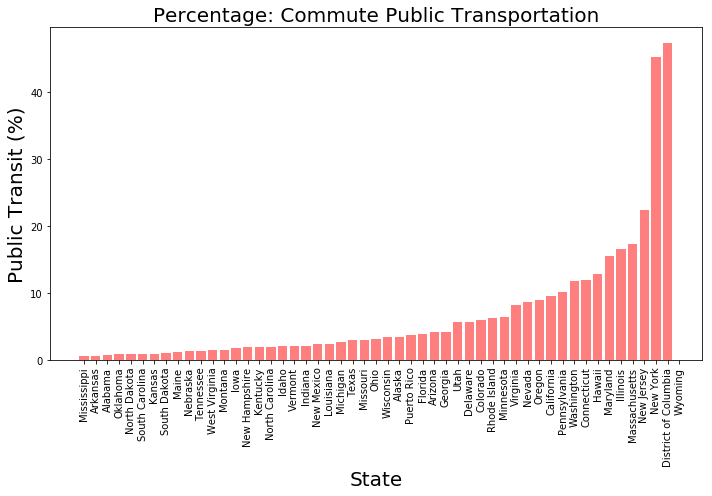

In [147]:
# This chart will show one calculated variable for commuting - percent who use public transit as primary mode
chart_commute_pd = calc_commute_pd.sort_values("Public Transit", ascending=True)
# chart_commute_pd.drop([-1])
# chart_commute_pd[chart_commute_pd["State"]!=Wyoming]
# chart_commute_pd.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
# chart_commute_pd

# Set x axis and tick locations'
x_axis = np.arange(len(chart_commute_pd))
tick_locations = [value+0.4 for value in x_axis]
# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(10,7))
plt.bar(x_axis, chart_commute_pd["Public Transit"], color='r', alpha=0.5, align="edge")
plt.xticks(tick_locations, chart_commute_pd["State"], rotation="vertical")

# Set x and y limits
# plt.xlim(-0.25, len(x_axis))
# plt.ylim(0, max(sort_income_pd["Public Transit"])+10)

# Set a Title and labels
plt.title("Percentage: Commute Public Transportation", fontsize=20)
plt.xlabel("State",fontsize=20)
plt.ylabel("Public Transit (%)", fontsize=20)

# Save our graph and show the grap
plt.tight_layout()
plt.savefig("images/Public transit commutters by State.png")